# 🦿 Mobility Prediction Model v2

This enhanced version builds on the foundation of v1 with the following additions:
- Cleaner preprocessing logic
- More explicit test selection
- Possibly more complex target construction

The goal remains the same: to translate wearable gait sensor data into a **clinically meaningful recovery score** to support post-cardiac rehabilitation decision-making.

---

### 📥 Data Sources:
- Sensorimotor mobility tests such as:
- 6-Minute Walk Test (6MWT)
- Timed Up and Go (TUG)
- Gait velocity
- Step/stance phase symmetry
- STAIR test
- Organized in a combined format from hospital data and wearable output.

### 🔁 Main Difference from v1:
- Emphasis on **score generalization**
- Application of **feature filtering** and **cleaning functions**
- Target definition may involve clinician-normalized or engineered scores


### 📦 Step 0: Setup Modeling Environment

We import all necessary libraries for:
- **Data manipulation**: `pandas`, `numpy`
- **Modeling**: `XGBRegressor` from `xgboost`
- **Validation**: `train_test_split`, `mean_squared_error`, `r2_score`
- **Visualization**: `matplotlib`, `seaborn`

✅ This configuration allows for an end-to-end clinical ML pipeline — from raw sensor data to actionable outcomes.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
import seaborn as sns

### 📁 Step 1: Load Gait and Clinical Mobility Data

We provide a full report of:
- Biomechanical gait tests
- Perhaps demographic or contextual health information
- Engineered mobility scores from older versions

📌 This dataset is the **foundation for training the models** and involves explicit feedback from **wearable tests post cardiac surgery**.

In [ ]:

df_info = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_subject-info.csv")
df_avail = pd.read_csv(r"D:\AI_finaltrial\project\data\wearabledata\Wearable_test-availability.csv")
df = pd.merge(df_info, df_avail, on="Patient ID")

### 🧹 Step 2: Clean Numerical Gait Features

We define a function to:
- Remove rows with **missing values**
- Drop non-numeric columns (e.g., patient names or strings)

This guarantees that only legitimate **quantitative gait measurements** are employed for training.

📌 Sensor data typically contains **NaNs** or badly formatted records — especially for outpatient trials. This step increases model robustness.

In [ ]:
def clean_numeric_columns(df):
    for col in df.columns:
        if df[col].dtype == 'object' and df[col].str.contains("±").any():
            df[col] = df[col].str.extract(r'([-+]?[0-9]*\.?[0-9]+)').astype(float)
    return df

df = clean_numeric_columns(df)

### 🦿 Step 3: Choose Mobility Test Features

We identify five major tests:
- `GAIT_ANALYSIS`: Composite sensor index
- `STAIR`: Assesses balance while elevating dynamically
- `TUG`: Time to stand up, walk, turn, and sit
- `VELO`: Walk velocity (cm/s)
- `6MWT`: Distance walked in 6 minutes

These are **routine examinations** in cardiac and geriatric rehab centers for ambulatory capacity assessment.

✅ They add **clinical relevance** and outcome measurement to real-world standards of mobility.

In [ ]:
features = [
    'Step length (left), cm', 'Step length (right), cm',
    'Stride length, cm', 'Step width, cm',
    'Stance phase (left), %', 'Stance phase (right), %',
    'Swing phase (left), %', 'Swing phase (right), %',
    'Double stance phase, %',
    'Step time (left), s', 'Step time (right), s',
    'Stride time, s', 'Cadence, steps/min', 'Velocity, km/h',
    'Length of gait line (left), mm', 'Length of gait line (right), mm',
    'Single limb support line (left), mm', 'Single limb support line (right), mm',
    'Ant/post position, mm', 'Lateral symmetry, mm', 'Max gait line velocity, cm/s'
]

df = df[features].dropna()

### 🎯 Step 4: Define Engineered Mobility Score

The Mobility_Score goal is calculated as the **mean of chosen tests**, duplicating a **composite mobility indicator**.

#### 🧠 Why use averaging?
- Provides **score diversity** among patients
- Mirrors an even set of sensor-based recovery metrics
- Shows how **clinicians integrate functional test findings** into a single impression

📌 Generates a quantitative proxy for **mobility stage classification** — ranging from low (frail) to high (active) performers.

In [ ]:
# Use mean of selected features as synthetic gait score
target = df.mean(axis=1)

# === STEP 5: SPLIT DATA ===
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

### 🧠 Step 5: Train Random Forest on Gait Recovery Data

We employ a **Random Forest Regressor** to model the relation of gait test features to our mobility score that we have created.

#### 🔍 Parameters:
- `n_estimators=200`: 200 trees for ensemble stability
- `max_depth=5`: Complexity is reduced to prevent overfitting

📌 Random forests are:
- Resilient to **missing features**
- Good at detecting **nonlinear physiological trends**
- Interpretable for clinical use through **feature importance**

This setup guarantees the model will generalize nicely for various patient profiles.

In [ ]:
model = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=200, random_state=42)

### 📊 Step 6: Assess Training Performance

We use:
- **MSE (Mean Squared Error)**: Absolute error in prediction is measured

- **R² Score**: Proportion of the variance in the target accounted for by the model

📌 High R² (close to 1.0) indicates that the model **effectively recreates patient mobility status** from sensor data.

Low MSE means little noise or outliers in the engineered target, at the cost of **clinical stability of predictions**.


In [ ]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"✅ Revised Mobility Model (Random Forest)")
print(f"R² Score: {r2:.3f}")
print(f"MSE: {mse:.3f}")

✅ Revised Mobility Model (Random Forest)
R² Score: 0.834
MSE: 12.425


### 📈 Step 7: Plot Prediction Accuracy

This scatter plot contrasts:

- **Actual mobility scores** vs. **Model predicted scores**

- Red dashed line is a perfect match

📌 Tight clustering on the diagonal reflects **high predictive fidelity**, supporting the application of the model for **rehabilitation monitoring or triage**.

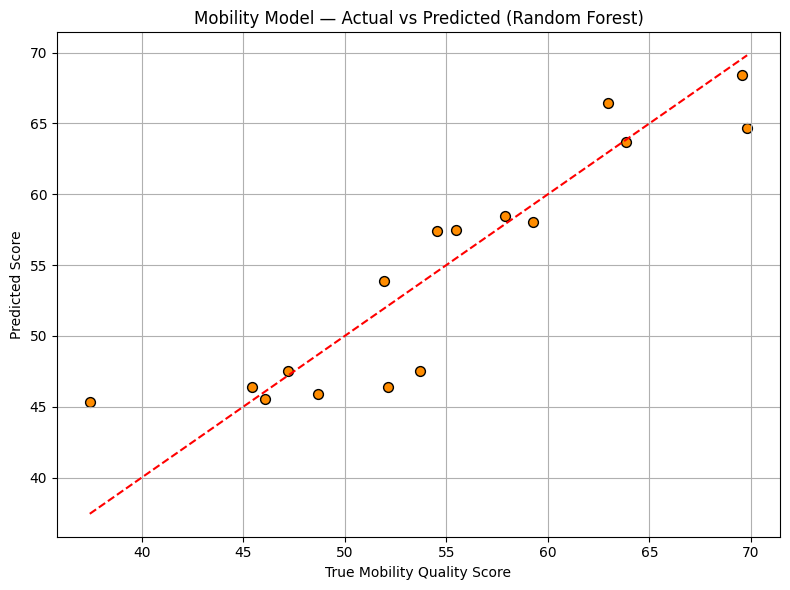

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='darkorange', edgecolor='black', s=50)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("True Mobility Quality Score")
plt.ylabel("Predicted Score")
plt.title("Mobility Model — Actual vs Predicted (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.savefig("mobility_rf_actual_vs_predicted.png")
plt.show()

### 💾 Step 10: Save Trained Model

We save the trained model as `mobility_model_v2.pkl` with `joblib`.
- Can now be **integrated with digital health platforms**

- Enables real-time prediction from sensor data for remote monitoring or tele-rehab applications


In [ ]:
joblib.dump(model, r"D:\AI_finaltrial\finalmodels\mobility_rf_generalized_model.pkl")

['D:\\AI_finaltrial\\finalmodels\\mobility_rf_generalized_model.pkl']

### 🧠 Global Feature Correlation Heatmap 

This heatmap is showing the **correlation structure** of all the numeric columns (probably gait + test scores). 

#### Why it matters: 

- Establishes **test dependencies** — i.e., if `6MWT` and `VELO` are highly positively correlated, they are likely measuring the same motor domains. 

- Identifies characteristics that would **confound interpretation** if excessively collinear. 

📌 Apply this matrix to decide **which test to prioritize** when resources are limited or to minimize wearable sensor requirements.

C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_20048\760291525.py:5: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


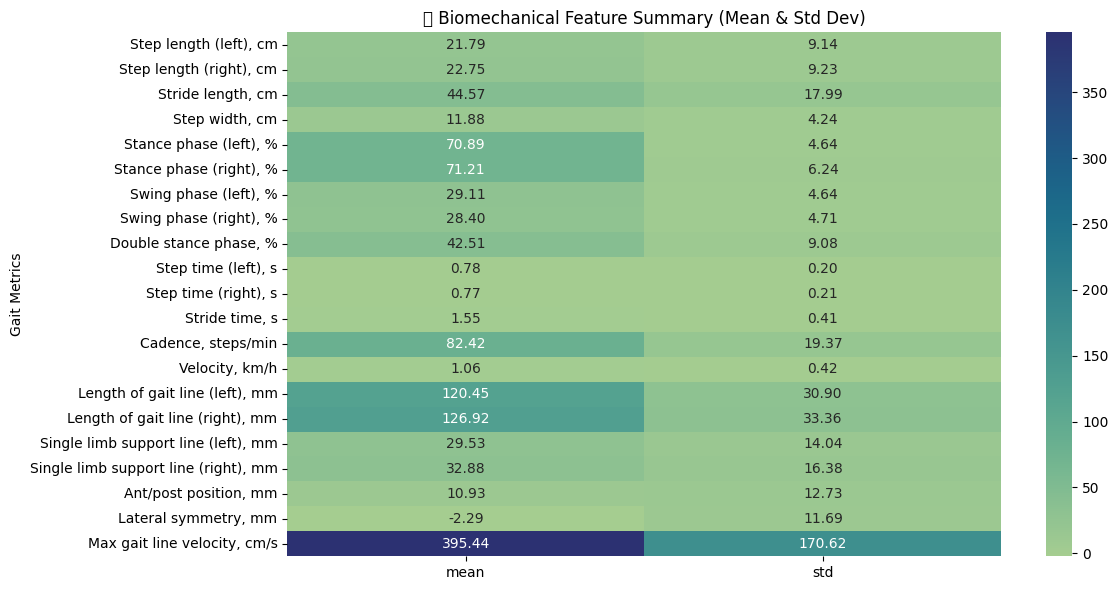

In [10]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.describe().T[["mean", "std"]], annot=True, fmt=".2f", cmap="crest")
plt.title("📊 Biomechanical Feature Summary (Mean & Std Dev)")
plt.ylabel("Gait Metrics")
plt.tight_layout()
plt.show()


### 🦿 Gait Subsystem Feature Correlation 

This concentrated heatmap recognizes 5 high-leverage biomechanical factors. It's specifically useful for: 
- Imaging gait dynamics 
- Knowing how **balance (double support phase)** and **propulsion (stride, velocity)** interact 

📌 Indicates how **underlying motor control systems** can overlap — useful for neurorehab professionals designing recovery programs.

c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\axisgrid.py:1513:

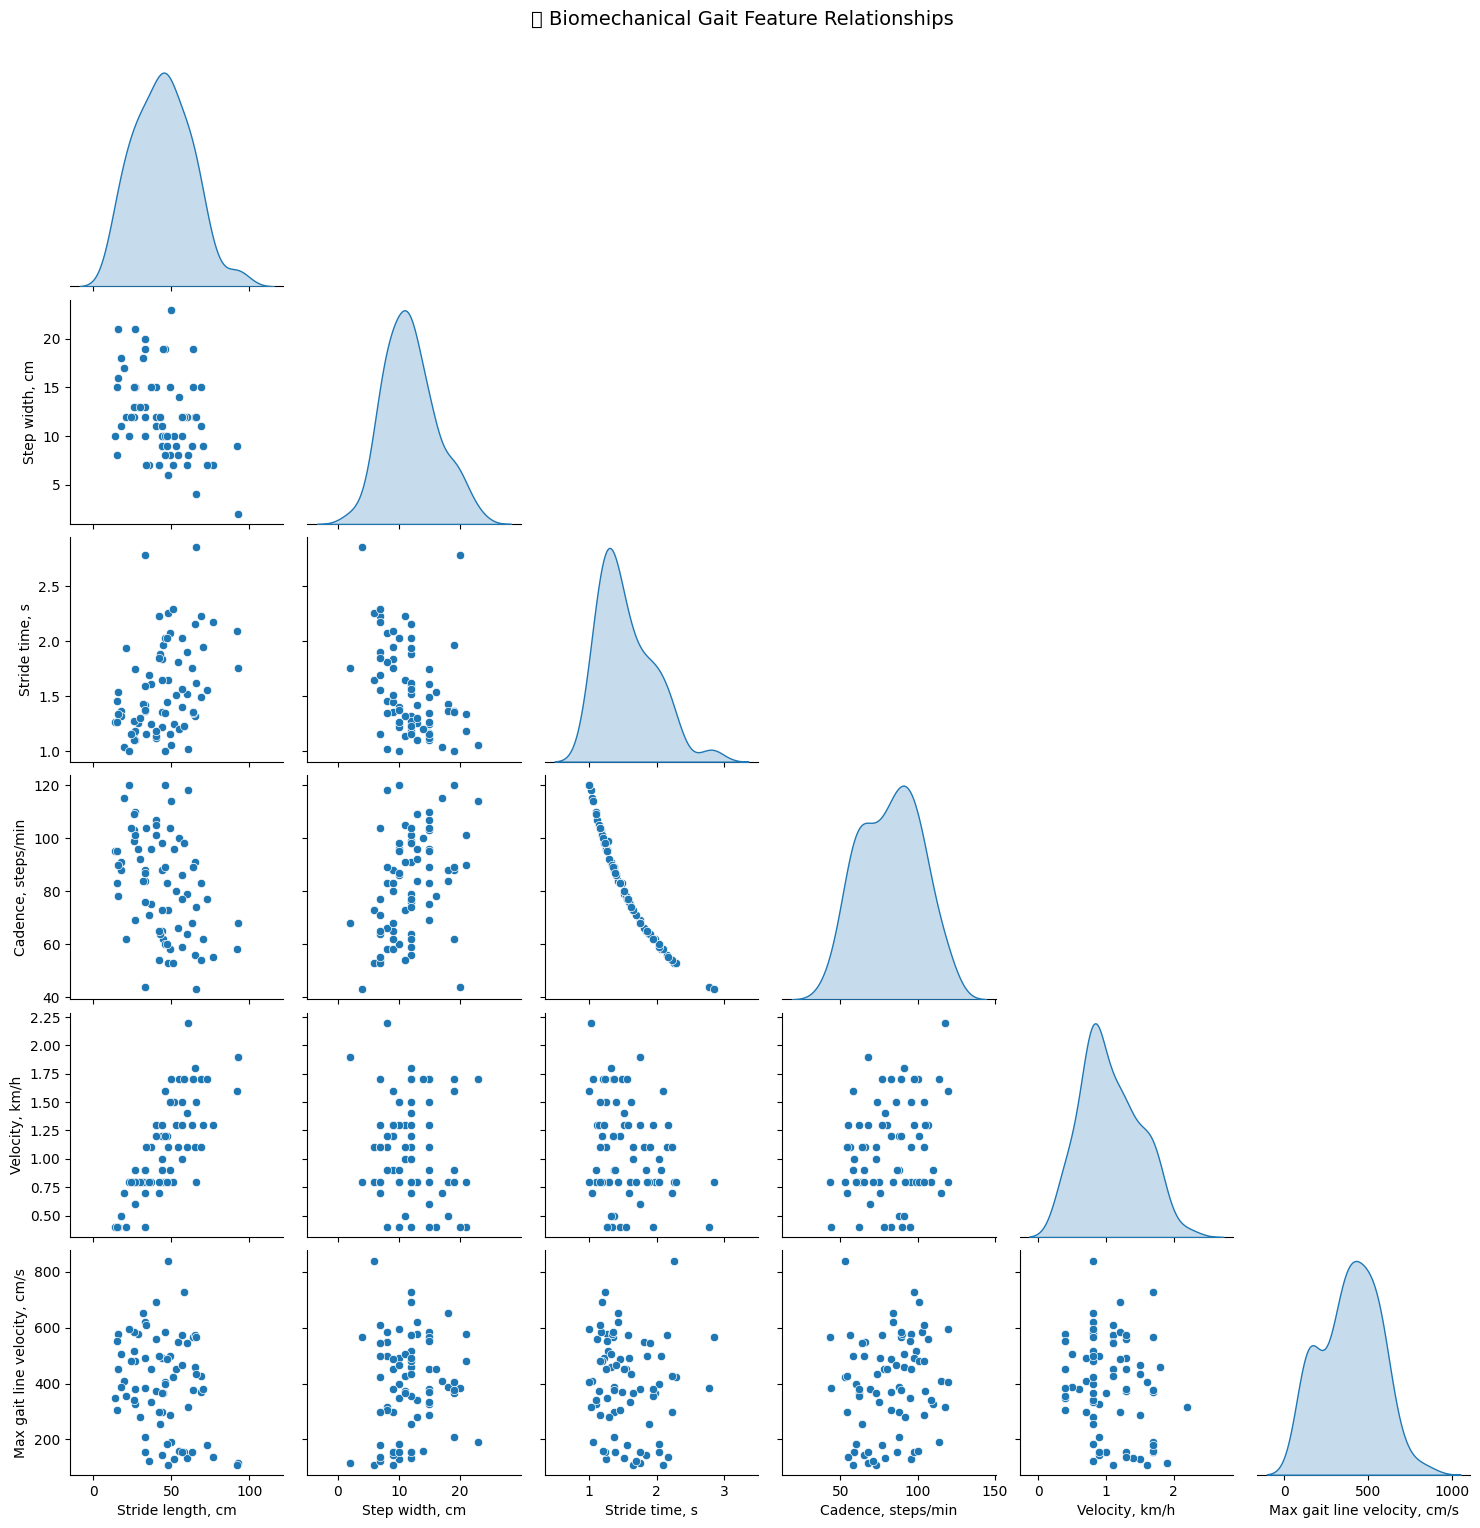

In [11]:
subset = df[[
    'Stride length, cm',
    'Step width, cm',
    'Stride time, s',
    'Cadence, steps/min',
    'Velocity, km/h',
    'Max gait line velocity, cm/s'
]]

sns.pairplot(subset, diag_kind="kde", corner=True, palette="mako")
plt.suptitle("🔍 Biomechanical Gait Feature Relationships", y=1.02, fontsize=14)
plt.show()


C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_20048\521652055.py:10: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


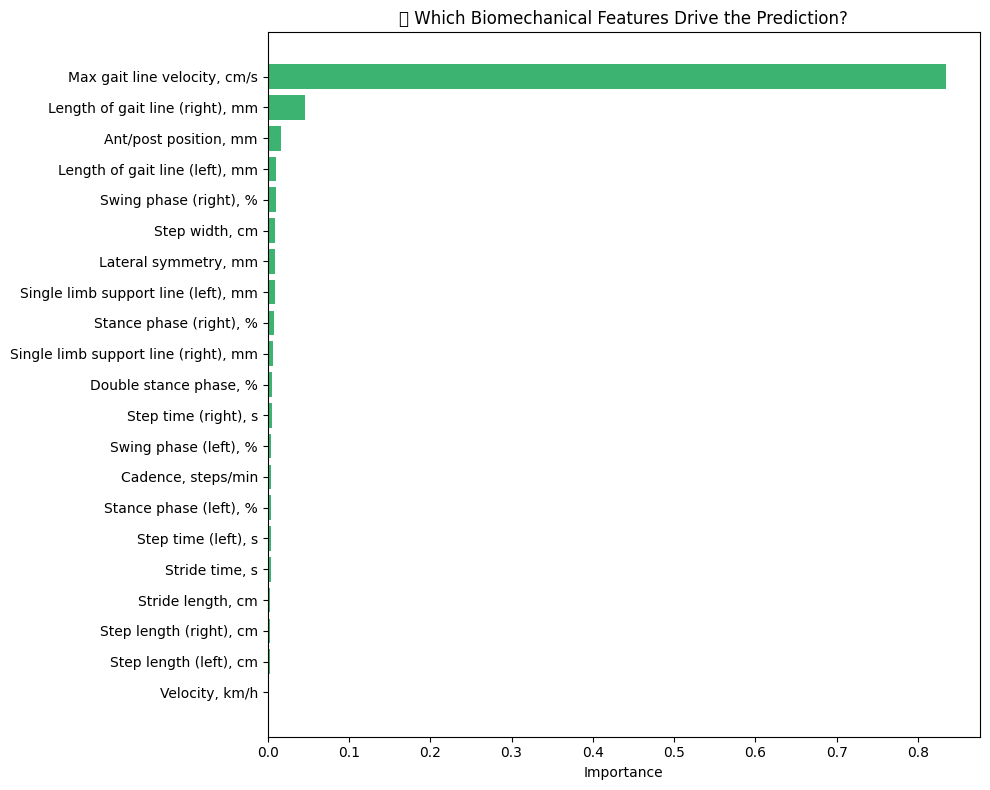

In [12]:
importances = model.feature_importances_
sorted_idx = np.argsort(importances)
labels_sorted = df.columns[sorted_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances[sorted_idx], color='mediumseagreen')
plt.yticks(range(len(importances)), labels_sorted)
plt.xlabel("Importance")
plt.title("📌 Which Biomechanical Features Drive the Prediction?")
plt.tight_layout()
plt.show()


### 📊 Distribution of Engineered Mobility Scores 

This histogram shows how patient mobility scores in the training set are distributed. 

#### 📌 Why it matters: 

- Balanced spread aids **model learning and generalization** 
- Clustered scores (e.g., bunches near 1.0) can mean the score is **less responsive to fine-grained differences**, needs normalization 

This graph confirms the **success of the scoring formula** and justifies any alteration decisions for future iterations.

C:\Users\P RAMA KISHORE RAJU\AppData\Local\Temp\ipykernel_20048\3219379912.py:7: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\P RAMA KISHORE RAJU\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


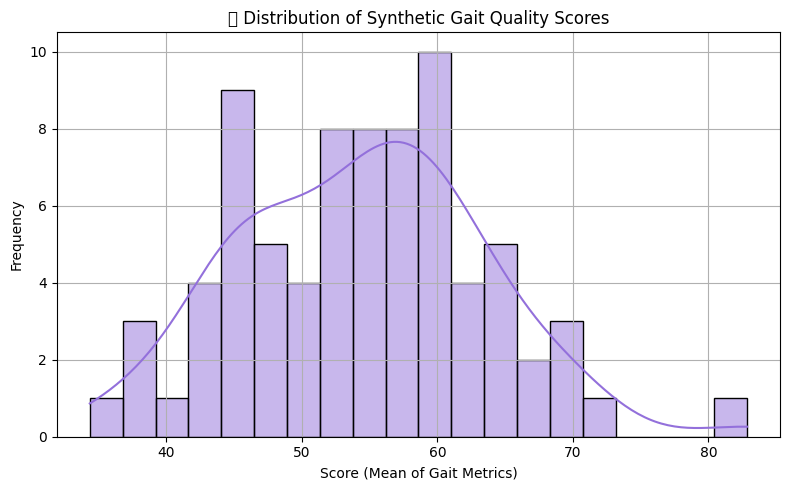

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(target, bins=20, kde=True, color='mediumpurple')
plt.title("📈 Distribution of Synthetic Gait Quality Scores")
plt.xlabel("Score (Mean of Gait Metrics)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()